# Multi-class Image Classification

In this notebook, we will classify cat and dog breeds. 

_(This uses a lot of the same sections of lesson 1 of the fast.ai course v3. For a more detailed overview, visit fastai course v3)_

---

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate

### Data preparation

We are going to use the Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. The fastai package conviniently stores the data in a public bucket:

In [2]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

To do this, we will use the untar_data method provided by fastai. The untar_data method will download the url (param1) to a file name (param2) and un-tgz to a new folder (param3).

In [3]:
path = untar_data(URLs.PETS, "../../data/pets-tar.tgz", "../../data/oxford-iiit-pet"); path

PosixPath('../data/oxford-iiit-pet')

Lets check that our data is in the path we've defined:

In [4]:
path.ls()

[PosixPath('../data/oxford-iiit-pet/annotations'),
 PosixPath('../data/oxford-iiit-pet/images')]

For this particular image classification problem, we only need to use the `/images` directory since the images are the labels themselves. Lets inspect it a small sample.

In [5]:
(path/'images').ls()[:5]

[PosixPath('../data/oxford-iiit-pet/images/keeshond_148.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu_129.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/scottish_terrier_143.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/basset_hound_118.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu_185.jpg')]

Now that we've seen our data, we know that the label is in the image title itself. However, the most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- Birman (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- Bulldog (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

Lets get our data into the format shown above.

In [6]:
import os
import shutil

for p in (path/'images').ls():
    # get the image file name
    image_filename = str(p).split('/')[-1]
    # extract the label (dog/cat breed) from filename
    label = "_".join(image_filename[:-4].split("_", -1)[:-1]).lower()
    # create a directory with the label name
    os.makedirs(path/'images'/label, exist_ok=True)
    # move image to the corresponding directory
    os.rename(path/'images'/image_filename, path/'images'/label/image_filename)

In [7]:
# check that label folders are created
(path/'images').ls()[:5]

[PosixPath('../data/oxford-iiit-pet/images/keeshond'),
 PosixPath('../data/oxford-iiit-pet/images/bengal'),
 PosixPath('../data/oxford-iiit-pet/images/american_bulldog'),
 PosixPath('../data/oxford-iiit-pet/images/miniature_pinscher'),
 PosixPath('../data/oxford-iiit-pet/images/american_pit_bull_terrier')]

In [8]:
# check that images are in label folders
(path/'images'/'shiba_inu').ls()[:5]

[PosixPath('../data/oxford-iiit-pet/images/shiba_inu/shiba_inu_129.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu/shiba_inu_185.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu/shiba_inu_192.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu/shiba_inu_145.jpg'),
 PosixPath('../data/oxford-iiit-pet/images/shiba_inu/shiba_inu_15.jpg')]

To use fastai, we want to create an ImageDataBunch so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

In [50]:
src = ImageItemList \
    .from_folder(path/'images') \
    .random_split_by_pct(valid_pct=0.2, seed=10) \
    .label_from_folder()

In [53]:
data = src \
    .transform(tfms=None, size=224) \
    .databunch(bs=48) \
    .normalize(imagenet_stats)

Lets take a look at our data using the databunch we created.

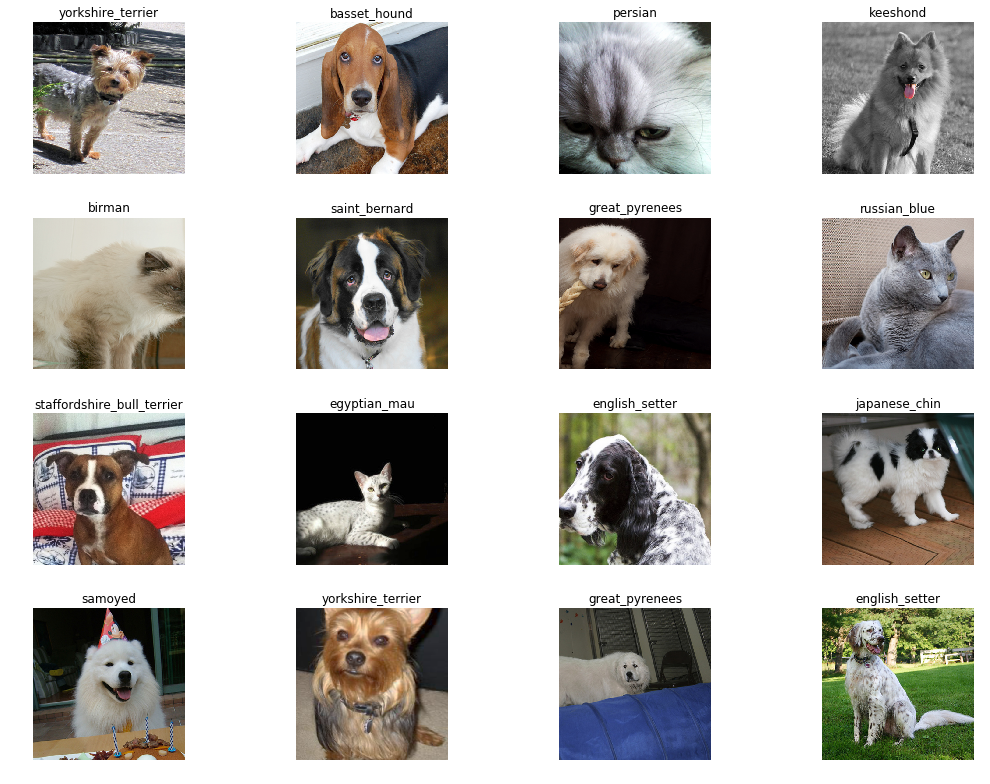

In [76]:
data.show_batch(rows=5, figsize=(15,11))

Lets see all available classes:

In [55]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 37
['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


### Training/Evaluating (part 1)
In as few lines of code as possible, lets build a model to classify dog and cat breeds. 

#### Training
For the model, we use a concolutional neural network. 

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. 

With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and a performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train imagenet. 

In [56]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

We can call the `fit` function to train the last layer of the dnn.

In [57]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate
1,0.575239,0.290973,0.101488
2,0.375996,0.257375,0.083897


In [ ]:
learn.save("part-1")

Not bad. In just one line of code, we're down to a pretty low error rate.

#### Evaluating

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

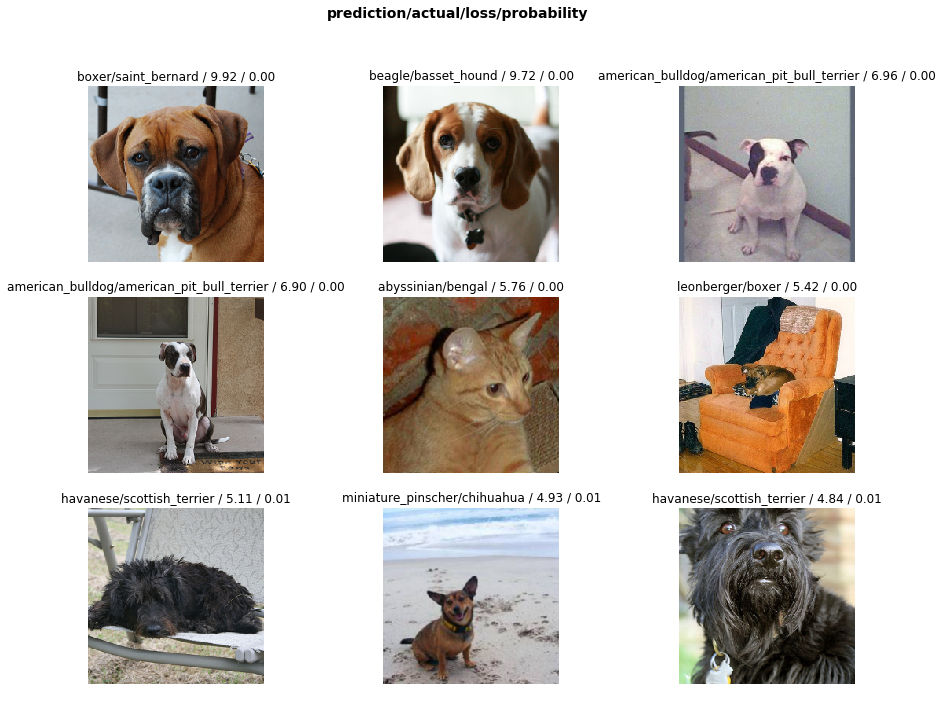

In [59]:
interp.plot_top_losses(9, figsize=(15,11))

We can also see which classes the model got most mixed up.

In [60]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('american_pit_bull_terrier', 'american_bulldog', 7),
 ('birman', 'ragdoll', 4),
 ('british_shorthair', 'russian_blue', 4),
 ('egyptian_mau', 'bengal', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('siamese', 'birman', 4),
 ('bengal', 'egyptian_mau', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('english_cocker_spaniel', 'newfoundland', 3),
 ('german_shorthaired', 'american_pit_bull_terrier', 3),
 ('russian_blue', 'british_shorthair', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('wheaten_terrier', 'havanese', 3),
 ('yorkshire_terrier', 'havanese', 3)]

### Training/Evaluating (part 2)

We've already trained the last layer of our model over a few epochs of the dataset so our weights on the last layer are already pretty reasonable. 

But lets see if we can do better using three techniques:
1. choosing the right learning rate
1. `fit_one_cycle` instead of `fit`
1. unfreeze layers and retrain

In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


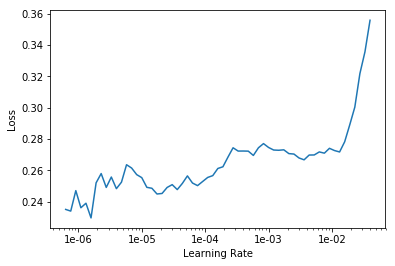

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.264855,0.226592,0.077808
2,0.222363,0.213050,0.069689


When you unfreeze your model, all the parameters in all layers of the model can be adjusted. So it is possible that the error_rate increase initially before decreasing again.

In [64]:
learn.unfreeze()

In [65]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.273207,0.284915,0.094723
2,0.281759,0.251684,0.087957
3,0.167850,0.188861,0.059540
4,0.098741,0.186222,0.058863


In [ ]:
learn.save("part-2")

Much more accurate!

### Training/Evaluation (part 3)

To improve out model performance even further, we can try using 
1. a deeper architecture (resnet50 instead of resnet34)
1. a higher resolution image size
1. data augmentation

We'll use image size 499 instead of 244:

In [66]:
data = src \
    .transform(get_transforms(), size=499) \
    .databunch(bs=16) \
    .normalize(imagenet_stats)

Lets use resnet50 instead of resnet 34:

In [67]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Now we repeat the same optimizations from before starting with only training the last layer.

In [68]:
learn.freeze() # make sure our dnn is frozen so that only the last layer is being tuned

Find a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


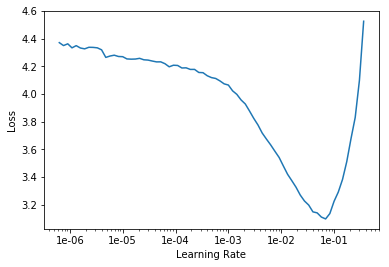

In [69]:
learn.lr_find()
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.578972,0.265040,0.089310
2,0.354434,0.190863,0.058187


In [71]:
learn.unfreeze()

In [72]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.461945,0.430584,0.128552
2,0.430073,0.331858,0.110961
3,0.355940,0.314951,0.096076
4,0.163525,0.193088,0.059540
5,0.093577,0.187447,0.058863


In [73]:
learn.save('part-3')

Lets re-evaluate our model.

In [74]:
interp = ClassificationInterpretation.from_learner(learn)

In [75]:
interp.most_confused(min_val=2)

[('ragdoll', 'birman', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('bengal', 'egyptian_mau', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('russian_blue', 'british_shorthair', 4),
 ('basset_hound', 'beagle', 3),
 ('egyptian_mau', 'bengal', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('ragdoll', 'persian', 3)]

### Recap
To recap our modeling steps:

1. First we want to just see how well our model performs with default settings so that we have a baseline to improve on.
1. Then we want to unfreeze layers and choose an optimal learning rate.
1. Finally we can try deeper architectures, higher resolution images, and data augmentation.